In [2]:
import pandas as pd

data = pd.read_csv('../data/inadimplentes.csv')

In [3]:
data.head()

,score_credito,idade,inadimplente
0,402,48,0
1,735,23,0
2,570,44,0
3,406,57,0
4,371,51,0


In [4]:
print ("Distribuição original: ", data['inadimplente'].value_counts(normalize=True))

Distribuição original:  inadimplente
0    0.857
1    0.143
Name: proportion, dtype: float64


In [5]:
X = data.drop('inadimplente', axis=1)
y = data['inadimplente']

In [6]:
from sklearn.metrics import (recall_score, precision_score, f1_score,
                            accuracy_score, confusion_matrix,
                            roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
from IPython.display import display

def avalia_modelo(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Recall': recall_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Acurácia': accuracy_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

    print("\nMatriz de Confusão:")
    display(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Previsto Não', 'Previsto Sim'],
             index=['Real Não', 'Real Sim']))

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('Curva ROC')
    plt.show()

    return pd.DataFrame([metrics])


Matriz de Confusão:


,Previsto Não,Previsto Sim
Real Não,147,110
Real Sim,21,22


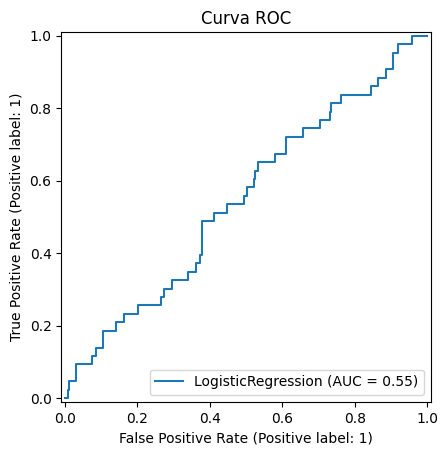

,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
0,0.511628,0.166667,0.251429,0.563333,0.546828


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Transforme variáveis categóricas em dummies
X_proc = pd.get_dummies(X, drop_first=True)

# 2. Padronize os dados
scaler = StandardScaler()
X_proc_scaled = scaler.fit_transform(X_proc)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Modelo com ajuste para desbalanceamento
modelo = LogisticRegression(class_weight='balanced')

holdout_metricas = avalia_modelo(X_train, X_test, y_train, y_test, modelo)
holdout_metricas

In [13]:
from sklearn.model_selection import KFold, cross_validate

# Validação cruzada tradicional

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_metrics = cross_validate(
    modelo, X_proc_scaled, y, cv=kf,
    scoring=['recall', 'precision', 'f1', 'accuracy', 'roc_auc'],
    return_train_score=False
)

print ("----Métricas k-fold tradicional----")
kfold_metricas = pd.DataFrame(
    { 'Recall': cv_metrics['test_recall'],
      'Precisão': cv_metrics['test_precision'],
      'F1-Score': cv_metrics['test_f1'],
      'Acurácia': cv_metrics['test_accuracy'],
      'AUC-ROC': cv_metrics['test_roc_auc']
      }
)
kfold_metricas

----Métricas k-fold tradicional----


,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
0,0.388889,0.138614,0.204380,0.455,0.382791
1,0.541667,0.147727,0.232143,0.570,0.624763
2,0.531250,0.168317,0.255639,0.505,0.504185
3,0.541667,0.127451,0.206349,0.500,0.493845
4,0.370370,0.095238,0.151515,0.440,0.412117


In [9]:
display(kfold_metricas.describe().loc[['mean', 'std']])

,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
mean,0.0,0.0,0.0,0.857000,0.483574
std,0.0,0.0,0.0,0.026363,0.093743


In [14]:
from sklearn.model_selection import StratifiedKFold

# Validação cruzada estratificada

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics_skf = cross_validate(
    modelo, X_proc_scaled, y, cv=skf,
    scoring=['recall', 'precision', 'f1', 'accuracy', 'roc_auc'],
    return_train_score=False
)

print ("----Métricas k-fold estratificada----")
skf_metricas = pd.DataFrame(
    { 'Recall': cv_metrics_skf['test_recall'],
      'Precisão': cv_metrics_skf['test_precision'],
      'F1-Score': cv_metrics_skf['test_f1'],
      'Acurácia': cv_metrics_skf['test_accuracy'],
      'AUC-ROC': cv_metrics_skf['test_roc_auc']
      }
)
skf_metricas

----Métricas k-fold estratificada----


,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
0,0.642857,0.171429,0.270677,0.515,0.582641
1,0.392857,0.114583,0.177419,0.490,0.443522
2,0.482759,0.172840,0.254545,0.590,0.556765
3,0.517241,0.159574,0.243902,0.535,0.510184
4,0.655172,0.179245,0.281481,0.515,0.568058


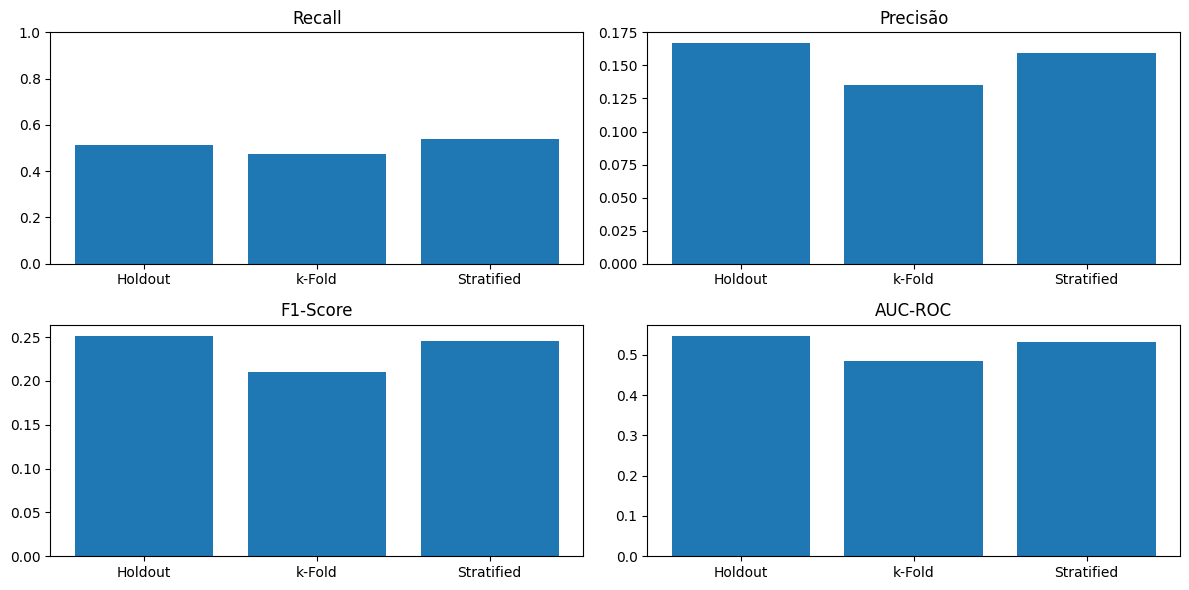

In [15]:
plt.figure(figsize=(12, 6))
metrics_list = ['Recall', 'Precisão', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics_list, 1):
    plt.subplot(2, 2, i)
    plt.bar(['Holdout', 'k-Fold', 'Stratified'],
            [holdout_metricas[metric].values[0],
             kfold_metricas[metric].mean(),
             skf_metricas[metric].mean()])
    plt.title(metric)
    if metric == 'Recall':
        plt.ylim(0, 1)

plt.tight_layout()
plt.show()

**Exercício 1:** Até aqui, ficou claro que a melhor abordagem para este dataset é a validação cruzada estratificada, mesmo ela não possuindo a melhor curva ROC como podemos ver no gráfico 4. Isso acontece porque o modelo é mais robusto já que foi exposto a dados equilibrados e diferentes em cada fase de treino e teste. Partido desse cenário, tente realizar algum pré-processamento nos dados e verifique se as métricas melhoram ou pioram.

**Exercício 2:** Pegue o dataset ``Titanic`` que usamos na aula 3 e faça a previsão de quem sobreviveu e quem faleceu. Decida qual a melhor estratégia de validação e descreva suas conclusões parciais a cada célula do seu Google Colab. Faça as devidas transformações nos dados.